In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pathlib
import os

MODEL = pathlib.Path('wall_recognizer.keras')
LABELLED = pathlib.Path('Dataset', 'Wall Recognizer', 'Labelled')

In [2]:
BUFFER = 128

file_paths = tf.data.Dataset.list_files(str(LABELLED/'*.png'), shuffle=False).shuffle(BUFFER, reshuffle_each_iteration=False)

In [3]:
def parse_images(file_path):
    # extract label
    label = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(label, '_')[:-1]
    label = tf.strings.to_number(label, tf.int32)

    # load image
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, [28, 28])
    image = tf.cast(image, tf.float32) / 255
    return image, label

dataset = file_paths.map(parse_images)

In [4]:
train_size = 800

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [5]:
image = iter(train_dataset).__next__()
print(image[0].shape)

(28, 28, 1)


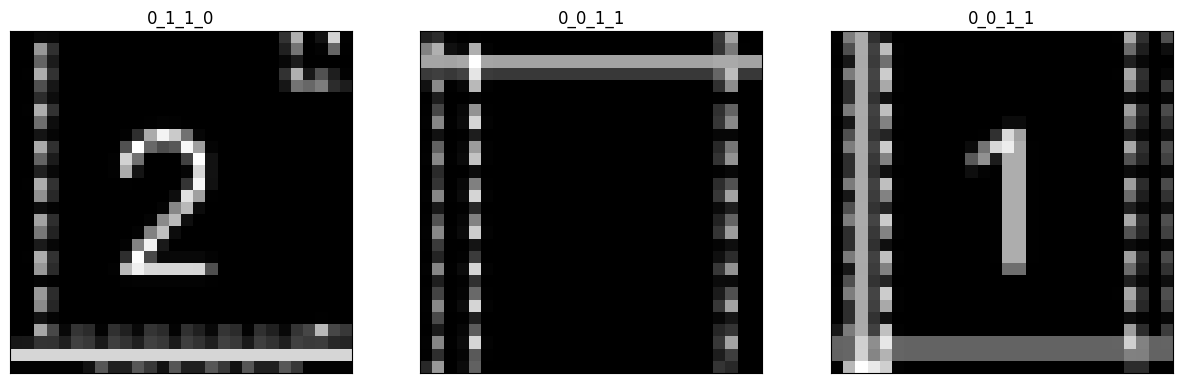

In [6]:
plt.figure(figsize=(15, 5))
for i, (image, label) in zip(range(3), iter(train_dataset)):
    label = label.numpy().astype(np.uint8).tolist()

    plt.subplot(1, 3, i + 1)
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('_'.join([str(x) for x in label]))
plt.show()

In [7]:
train_dataset = train_dataset.batch(1)
test_dataset = test_dataset.batch(1)

In [8]:
def get_model():
    model = keras.Sequential()

    # input layer
    model.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))

    # first convolution layer
    model.add(keras.layers.Conv2D(32, (5, 5), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # second convolution layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # transition to fully connected layers
    model.add(keras.layers.Flatten())

    # first dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # second dense layer
    model.add(keras.layers.Dense(64, kernel_initializer='he_uniform'))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(4, kernel_initializer='he_uniform', activation='sigmoid'))
    return model

In [9]:
# create a model
model = get_model()
print(model.summary())
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics='accuracy'
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                 

In [10]:
for file in os.listdir('Checkpoints'):
    os.remove(f'Checkpoints/{file}')

In [11]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [12]:
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=[model_checkpoint_callback])

Epoch 1/100


800/800 [==============================] - 4s 4ms/step - loss: 0.5340 - accuracy: 0.2650 - val_loss: 0.3739 - val_accuracy: 0.9803
Epoch 2/100
 33/800 [>.............................] - ETA: 2s - loss: 0.7282 - accuracy: 0.2424  

c:\Users\lohzh\Desktop\Killer sudoku\killer-sudoku\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 [==============================] - 3s 3ms/step - loss: 0.4115 - accuracy: 0.3425 - val_loss: 0.2005 - val_accuracy: 0.9567
Epoch 3/100
800/800 [==============================] - 3s 3ms/step - loss: 0.3324 - accuracy: 0.3125 - val_loss: 0.1830 - val_accuracy: 0.8701
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: 0.2585 - accuracy: 0.3738 - val_loss: 0.1884 - val_accuracy: 0.7717
Epoch 5/100
800/800 [==============================] - 3s 3ms/step - loss: 0.2247 - accuracy: 0.3700 - val_loss: 0.1551 - val_accuracy: 0.8346
Epoch 6/100
800/800 [==============================] - 3s 3ms/step - loss: 0.1799 - accuracy: 0.3600 - val_loss: 0.1642 - val_accuracy: 0.5394
Epoch 7/100
800/800 [==============================] - 3s 4ms/step - loss: 0.1670 - accuracy: 0.3850 - val_loss: 0.1522 - val_accuracy: 0.5669
Epoch 8/100
800/800 [==============================] - 4s 6ms/step - loss: 0.1567 - accuracy: 0.3700 - val_loss: 0.1081 - val_accuracy: 0.2913
Epoch 9/100

In [13]:
model.evaluate(test_dataset)

254/254 [==============================] - 1s 2ms/step - loss: 0.1800 - accuracy: 0.1575


[0.17996624112129211, 0.15748031437397003]

In [14]:
predictions = (model.predict(test_dataset) < 0.5)[0]
tuple(predictions)

254/254 [==============================] - 1s 3ms/step


(False, False, False, True)